## Concorde TSP  
from:   
https://www.kaggle.com/blacksix/concorde-for-5-hours  
https://www.kaggle.com/blacksix/concorde-for-5-min

In [1]:
%%bash -e
if ! [[ -f ./linkern ]]; then
  wget http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/src/co031219.tgz
  echo 'c3650a59c8d57e0a00e81c1288b994a99c5aa03e5d96a314834c2d8f9505c724  co031219.tgz' | sha256sum -c
  tar xf co031219.tgz
  (cd concorde && CFLAGS='-Ofast -march=native -mtune=native -fPIC' ./configure)
  (cd concorde/LINKERN && make -j && cp linkern ../../)
  rm -rf concorde co031219.tgz
fi

co031219.tgz: OK
creating cache ./config.cache
checking host system type... 
checking for prespecified compiler options... no
checking for gcc... gcc
checking whether the C compiler (gcc -Ofast -march=native -mtune=native -fPIC ) works... yes
checking whether the C compiler (gcc -Ofast -march=native -mtune=native -fPIC ) is a cross-compiler... no
checking whether we are using GNU C... yes
checking whether gcc accepts -g... yes
checking whether make sets ${MAKE}... yes
checking for ranlib... ranlib
checking for sh... /bin/sh
checking for file suffixes... o, a, 
checking for sqrt in -lm... yes
checking for -lnsl... no
checking for -lsocket... no
checking for bfd_open_file in -lbfd... no
checking for xstrerror in -liberty... no
checking how to run the C preprocessor... gcc -E
checking for ANSI C header files... yes
checking whether time.h and sys/time.h may both be included... yes
checking for stdlib.h... yes
checking for math.h... yes
checking for string.h... yes
checking for strings.h..

--2018-12-10 01:34:14--  http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/src/co031219.tgz
www.math.uwaterloo.ca (www.math.uwaterloo.ca) をDNSに問いあわせています... 129.97.140.120
www.math.uwaterloo.ca (www.math.uwaterloo.ca)|129.97.140.120|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 698592 (682K) [application/x-gzip]
`co031219.tgz' に保存中

     0K .......... .......... .......... .......... ..........  7% 73.6K 9s
    50K .......... .......... .......... .......... .......... 14%  208K 5s
   100K .......... .......... .......... .......... .......... 21%  195K 4s
   150K .......... .......... .......... .......... .......... 29%  111K 4s
   200K .......... .......... .......... .......... .......... 36% 1.27M 3s
   250K .......... .......... .......... .......... .......... 43%  123M 2s
   300K .......... .......... .......... .......... .......... 51%  303K 2s
   350K .......... .......... .......... .......... .......... 58%  707K 1s
   400K .......... .........

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
from numba import jit

In [2]:
def read_cities(filename='input/cities.csv'):
    return pd.read_csv(filename, index_col=['CityId'])

cities = read_cities()

In [3]:
cities1k = cities * 1000

In [8]:
def write_tsp(cities, filename, name='traveling-santa-2018-prime-paths'):
    with open(filename, 'w') as f:
        f.write('NAME : %s\n' % name)
        f.write('COMMENT : %s\n' % name)
        f.write('TYPE : TSP\n')
        f.write('DIMENSION : %d\n' % len(cities))
        f.write('EDGE_WEIGHT_TYPE : EUC_2D\n')
        f.write('NODE_COORD_SECTION\n')
        for row in cities.itertuples():
            f.write('%d %.11f %.11f\n' % (row.Index+1, row.X, row.Y))
        f.write('EOF\n')

write_tsp(cities1k, 'cities1k.tsp')

In [9]:
%%bash
time ./linkern -K 1 -s 42 -S linkern.tour -R 999999999 -t 300 ./cities1k.tsp >linkern.log


real	5m1.707s
user	5m1.331s
sys	0m0.310s


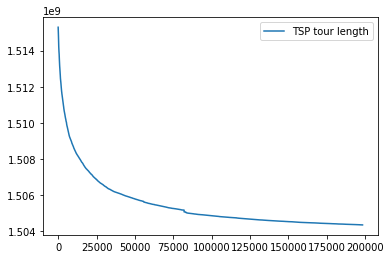

In [10]:
!sed -Ene 's/([0-9]+) Steps.*Best: ([0-9]+).*/\1,\2/p' linkern.log >linkern.csv
pd.read_csv('linkern.csv', index_col=0, names=['TSP tour length']).plot();

In [11]:
class Tour:
    cities = read_cities()
    coords = (cities.X + 1j * cities.Y).values
    penalized = ~cities.index.isin(sympy.primerange(0, len(cities)))

    def __init__(self, data):
        """Initializes from a list/iterable of indexes or a filename of tour in csv/tsplib/linkern format."""

        if type(data) is str:
            data = self._read(data)
        elif type(data) is not np.ndarray or data.dtype != np.int32:
            data = np.array(data, dtype=np.int32)
        self.data = data

        if (self.data[0] != 0 or self.data[-1] != 0 or len(self.data) != len(self.cities) + 1):
            raise Exception('Invalid tour')

    @classmethod
    def _read(cls, filename):
        data = open(filename, 'r').read()
        if data.startswith('Path'):  # csv
            return pd.read_csv(io.StringIO(data)).Path.values
        offs = data.find('TOUR_SECTION\n')
        if offs != -1:  # TSPLIB/LKH
            data = np.fromstring(data[offs+13:], sep='\n', dtype=np.int32)
            data[-1] = 1
            return data - 1
        else:  # linkern
            data = data.replace('\n', ' ')
            data = np.fromstring(data, sep=' ', dtype=np.int32)
            if len(data) != data[0] + 1:
                raise Exception('Unrecognized format in %s' % filename)
            return np.concatenate((data[1:], [0]))

    def info(self):
        dist = np.abs(np.diff(self.coords[self.data]))
        penalty = 0.1 * np.sum(dist[9::10] * self.penalized[self.data[9:-1:10]])
        dist = np.sum(dist)
        return { 'score': dist + penalty, 'dist': dist, 'penalty': penalty }

    def dist(self):
        return self.info()['dist']

    def score(self):
        return self.info()['score']

    def __repr__(self):
        return 'Tour: %s' % str(self.info())

    def to_csv(self, filename):
        pd.DataFrame({'Path': self.data}).to_csv(filename, index=False)

In [12]:
tour = Tour('linkern.tour')
tour # Tour: {'score': 1518043.4728760184, 'dist': 1504346.798813631, 'penalty': 13696.674062387363}

Tour: {'score': 1518043.4728760184, 'dist': 1504346.798813631, 'penalty': 13696.674062387363}

In [13]:
tour.to_csv('submission.csv')

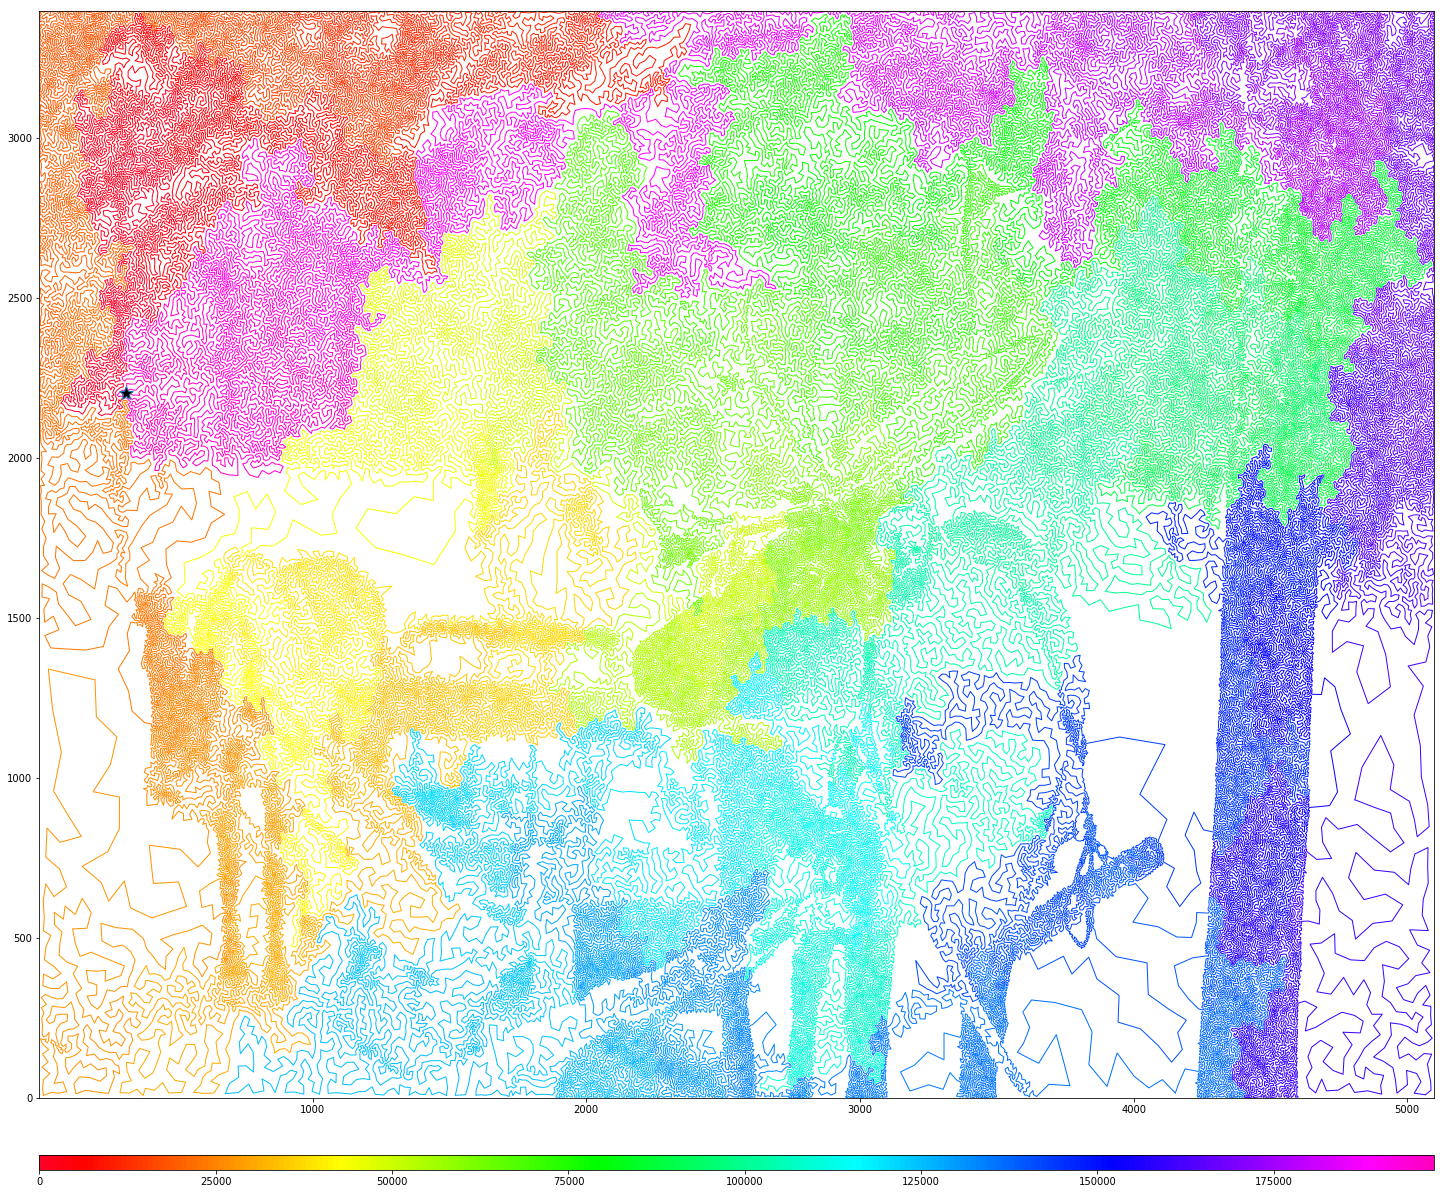

In [14]:
def plot_tour(tour, cmap=mpl.cm.gist_rainbow, figsize=(25, 20)):
    fig, ax = plt.subplots(figsize=figsize)
    n = len(tour.data)

    for i in range(201):
        ind = tour.data[n//200*i:min(n, n//200*(i+1)+1)]
        ax.plot(tour.cities.X[ind], tour.cities.Y[ind], color=cmap(i/200.0), linewidth=1)

    ax.plot(tour.cities.X[0], tour.cities.Y[0], marker='*', markersize=15, markerfacecolor='k')
    ax.autoscale(tight=True)
    mpl.colorbar.ColorbarBase(ax=fig.add_axes([0.125, 0.075, 0.775, 0.01]),
                              norm=mpl.colors.Normalize(vmin=0, vmax=n),
                              cmap=cmap, orientation='horizontal')

plot_tour(tour)

In [2]:
from sympy import isprime, primerange
df = pd.read_csv('submission.csv')
cities = pd.read_csv('input/cities.csv')

prime_list = list(primerange(0, len(cities)))

In [3]:
penalized = ~cities.index.isin(sympy.primerange(0, len(cities)))

In [150]:
# def dist(index_a, index_b):
#     d = ((cities.X[index_a] - cities.X[index_b])**2 + (cities.Y[index_a] - cities.Y[index_b])**2)**0.5
#     #d = cities.X[index_a] + 1j * cities.Y[index_a]
#     return d

In [197]:
# def dist2(a, b):
#     A = cities.X[a] + 1j * cities.Y[a]
#     B = cities.X[b] + 1j * cities.Y[b]
#     d = abs(A-B)
#     return d

In [75]:
complex_n = np.array(cities.X + 1j * cities.Y)
def dist3(a, b):
    d = abs(complex_n[a] - complex_n[b])
    return d

In [89]:
@jit
def total_score(path):
    score = 0
    score_np = 0
    np = 0
    for i in range(1, len(path)):
        d = dist3(path[i-1], path[i])
        score_np += d
        if i % 10 == 0:
            if not isprime(path[i-1]):
                d = d * 1.1
            else:
                np += 1
        score += d
    return score, score_np, np  

In [92]:
df_path = np.array(df.Path)
total_score(df_path)

(1518043.4728760002, 1504346.7988136157, 1815)

In [49]:
def scores(a, b):
    c = []
    for i, n in enumerate(df.Path):
        if i >= a and i <= b:
            c.append(complex_n[n])
    score = np.sum(np.abs(np.diff(c)))
    return score

In [93]:
@jit
def scores2(a, b):
    c = []
    for i in df_path[a: b+1]:
        c.append(complex_n[i])
    score = np.sum(np.abs(np.diff(c)))
    return score

In [94]:
scores2(0, len(df.Path)) # 1504346.798813631

1504346.798813631

In [232]:
def closest(base_index):
    min_dist = np.inf
    closest_index = -1
    for i in range(1, len(df.Path)):
        d = dist3(df.Path[base_index], df.Path[i])
        if d < min_dist and df.Path[i] != 0 :
            min_dist = d
            closest_index = df.Path[i]
    return closest_index

In [263]:
# 0 - 1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12
#                                 8  p9 - 10

def closest_prime(base_index):
    min_dist = np.inf
    closest_index = -1
    for i in prime_list:
        d = dist3(base_index, i)
        if d < min_dist and i != base_index:
            min_dist = d
            closest_index = i
    return closest_index

In [248]:
closest_prime(8)

38447